# Import Packages

In [1]:
# Import packages
import random
import math
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikit_posthocs as sp
import dataframe_image as dfi

from sklearn.utils import resample
from scipy.stats import beta, f_oneway, kruskal, ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from collections import OrderedDict

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

# Algorithms 
* Random (for baseline comparison)
* Without tuning
 * Epsilon Decay
 * Annealing Softmax
 * UCB1
 * Bayesian UCB
 * Thompson Sampling
* With Tuning
 * Epsilon Greedy
 * Softmax

### Random

In [2]:
def random_policy(history, arms):
    chosen_arm = np.random.choice(arms, replace = False)
    return chosen_arm

## Algorithms Without Tuning
* Epsilon Decay
* Annealing Softmax
* UCB1
* Bayesian UCB
* Thompson Sampling

### Epsilon Decay

In [3]:
def epsilon_decay(history, arms):
    
    epsilon = 1 / (sum(history["count"]) / len(arms) + 1)
    
    if random.random() > epsilon: # exploit
        ranks = history.sort_values(by = ['mean'], ascending = False) 
        chosen_arm = ranks.iloc[0]['arm']
    else: # explore
        chosen_arm = np.random.choice(arms, replace = False)
    
    return chosen_arm

### Annealing Softmax

In [4]:
def annealing_softmax(history, arms):
    
    temp = 1 / (sum(history["count"]) / len(arms) + 1)

    z = sum([np.exp(v / temp) for v in history["mean"]])
    pi = [np.exp(v / temp) / z for v in history["mean"]]
    chosen_arm = np.random.choice(arms, p = pi)
    
    return chosen_arm

### UCB1 (CHECK)

In [5]:
def ucb1(history, arms):

    n_arms = len(arms)
    
    for arm in range(n_arms):
        if int(history["count"][arm]) == 0:
            chosen_arm = history["arm"][arm]
            return chosen_arm
    
    ucb_values = [0.0 for arm in range(n_arms)]
    total_counts = sum(history["count"])
    
    for arm in range(n_arms):
        bonus = math.sqrt((2*math.log(total_counts)) / (float(history["count"][arm])))
        ucb_values[arm] = history["mean"][arm] + bonus
    
    chosen_arm = ucb_values.index(max(ucb_values)) + 1
    
    return chosen_arm

### Bayesian UCB (CHECK)

In [6]:
def bayesian_ucb(history, arms):
    
    n_arms = len(arms)
    
    chosen_arm = max(range(n_arms), 
                     key = lambda x: container["alpha"][x] / float(container["alpha"][x] + container["beta"][x]) 
                     + beta.std(container["alpha"][x], container["beta"][x]) * 3) + 1
    
    return chosen_arm

### Thompson Sampling (CHECK)

In [7]:
def thompson_sampling(history, arms):
    
    n_arms = len(arms)
    
    thetas = [np.random.beta(container["alpha"][x], container["beta"][x]) for x in range(n_arms)]
    chosen_arm = max(range(n_arms), 
                     key = lambda x: thetas[x]) + 1
    
    return chosen_arm

## Algorithm with Tuning
* Epsilon Greedy
* Softmax

### Epsilon Greedy (CHECK)

In [8]:
def epsilon_greedy(history, arms, epsilon):
    
    explore = np.random.binomial(1, epsilon)
            
    if explore == 1 or history.shape[0] == 0:
        chosen_arm = np.random.choice(arms, replace=False)
    else:
        ranks = history.sort_values(by=['mean'], ascending=False) 
        chosen_arm = ranks.iloc[0]['arm']
        
    return chosen_arm

### Softmax

In [9]:
def softmax(history, arms, temp):
    
    z = sum([math.exp(v / temp) for v in history["mean"]])
    pi = [math.exp(v / temp) / z for v in history["mean"]]
    chosen_arm = np.random.choice(arms, p = pi)
    
    return chosen_arm

### LinUCB

In [10]:
def linucb(history, arms, context, alpha = 0.1):
    scores = np.zeros(len(arms))
    thetas = [np.zeros(2) for _ in range(len(arms))]
    for arm in range(len(arms)):
        A_inv = np.linalg.inv(history['A'][arm])
        theta = A_inv @ history['b'][arm]
        # context_arm = np.array(np.random.uniform(low = 0, high = 1, size = 2)) * context
        p_arm = theta.T @ context + alpha * np.sqrt(context.T @ A_inv @ context)
        scores[arm] = p_arm
        thetas[arm] = theta
    chosen_arm = np.argmax(scores) + 1
    return chosen_arm

### LinTS

In [11]:
def linTS(history, arms, context):
    R = 0.01
    epsilon = 0.5 
    delta = 0.5
    v = R * np.sqrt(24 / epsilon * 2 * np.log(1 / delta))
    
    scores = np.zeros(len(arms))
    thetas = [np.zeros(2) for _ in range(len(arms))]
    for arm in range(len(arms)):
        mu_tilde = np.random.multivariate_normal(container['mu_hat'][arm].flat, v**2 * np.linalg.inv(container['B'][arm]))[..., np.newaxis]
        # theta = 1/(1+np.exp(-1 * container['F'][arm]))
        theta = 1/(1+np.exp(-1 * container['B'][arm].dot(container['mu_hat'][arm])))
        scores[arm] = context.dot(mu_tilde)
        thetas[arm] = theta
    chosen_arm = np.argmax(scores) + 1
    return chosen_arm

# Plots

In [12]:
def plot_multiple_boxplots(data: pd.DataFrame, grouped_col: str, target_col: str,
                           palette: str = "husl"):
    plt.figure(figsize=(12, 10))

    means: dict = data.groupby([grouped_col])[target_col].mean().to_dict(OrderedDict)
    counter: int = 0

    bp = sns.boxplot(x=grouped_col, y=target_col, data=data, palette=palette, order=list(means.keys()))
    bp.set(xlabel='', ylabel=f"{target_col.title()}")
    ax = bp.axes

    for k, v in means.items():
        mean = round(v, 4)
        ax.text(
            counter,
            mean,
            f'{mean}',
            ha='center',
            va='center',
            fontweight='bold',
            size=10,
            color='white',
            bbox=dict(facecolor='#445A64'))
        counter += 1
    bp.figure.tight_layout()
    plt.grid()
    plt.show()

In [13]:
def get_labels_colors_from_pandas_column(df: pd.DataFrame, column: str, palette: str):
    data_labels: dict = dict()
    labels: list = df[column].unique().tolist()
    colors: list = sns.color_palette(palette, len(labels))
    data_labels: dict = dict(zip(labels, colors))
    return data_labels

# Bootstrap Replay

In the bootstrapped replay, please output a dataframe, which contains the following columns: policy, time_step, reward, cumulative_reward

In [14]:
logs_df = pd.read_csv("../Data Cleaning/cleaned_dataset.csv")
# logs_df = pd.read_csv("cleaned_dataset.csv")
# logs_df = pd.read_csv("cleaned_dataset_all.csv")
logs_df.loc[logs_df['AGE'] == 'OLD', 'AGE_new'] = 1
logs_df.loc[logs_df['AGE'] == 'YOUNG', 'AGE_new'] = 0
logs_df["AGE_new"] = logs_df["AGE_new"].astype(int)
# GENDER: M = 1, F = 0
logs_df.loc[logs_df['SEX'] == 'M', 'SEX_new'] = 1
logs_df.loc[logs_df['SEX'] == 'F', 'SEX_new'] = 0
logs_df["SEX_new"] = logs_df["SEX_new"].astype(int)
logs_df

,SEX,AGE,RXASP,RXHEP,FDEAD,FDENNIS,FRECOVER,RXHEP_1,TREATMENT,REWARD_BERNOULLI,REWARD_CATEGORICAL,REWARD_VALUE (BER),REWARD_VALUE (CAT),AGE_new,SEX_new
0,M,YOUNG,Y,L,N,U,U,L,4,Alive,Alive with unknown status,1,1,0,1
1,M,OLD,Y,L,Y,NaN,NaN,L,4,Dead,Dead,0,0,1,1
2,M,OLD,N,N,Y,NaN,NaN,N,1,Dead,Dead,0,0,1,1
3,M,YOUNG,Y,N,N,Y,N,N,3,Alive,Alive and still dependent,1,2,0,1
4,F,YOUNG,Y,N,N,N,Y,N,3,Alive,Alive and recovered,1,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,F,OLD,N,N,N,N,N,N,1,Alive,Alive and recovered,1,3,1,0
2496,M,OLD,Y,N,Y,NaN,NaN,N,3,Dead,Dead,0,0,1,1
2497,F,OLD,N,L,N,N,N,L,2,Alive,Alive and recovered,1,3,1,0
2498,M,YOUNG,Y,L,Y,NaN,NaN,L,4,Dead,Dead,0,0,0,1


In [15]:
def get_reward_prob(df):
    rewards_list = ['Alive and still dependent', 'Alive and recovered', 'Dead', 'Alive with unknown status']
    probs_list = []
    for i in range(4):
        prob = sum(df[df["REWARD_CATEGORICAL"] == rewards_list[i]]["REWARD_VALUE (CAT)"]) / sum(df["REWARD_CATEGORICAL"].value_counts())
        probs_list.append(prob)
    probs_list = [x/sum(probs_list) for x in probs_list]
    return probs_list

get_reward_prob(logs_df)

[0.4139818909244051, 0.5837018319646241, 0.0, 0.0023162771109707307]

In [16]:
# Generate boostrap resamples
def bootstrap_samples(df, n_samples):
    # Creation of bootstrap resamples
    bsamples = []

    for i in range(5):
        bsample = resample(df, replace = True, n_samples = n_samples, random_state = i)
        bsamples.append(bsample)
    
    return bsamples

In [17]:
# Describe your data
arms = logs_df["TREATMENT"].unique()
log_length = logs_df.shape[0]
n_samples = log_length * len(arms)
arms

array([4, 1, 3, 2], dtype=int64)

## Bernoulli Arm

In [18]:
# Set seed for reproducibility
random.seed(4014)
np.random.seed(4014)

# Retrieving resamples
bsamples = bootstrap_samples(logs_df, n_samples)

# The algos used
algos = [random_policy, epsilon_decay, annealing_softmax, ucb1, bayesian_ucb, thompson_sampling, epsilon_greedy, softmax, linucb, linTS]
# algos = [linucb]

# Define a dataframe for evaluation results
evaluation_ber = []

# Define a list to save all arm-play statistics
play_stats = []

# Check algos
count_algos = 0

# Running bootstrap replay
for f in algos:
    
    count_algos += 1
    
    # Count samples
    sample_no = 0

    for bsample in bsamples:
        # Define a container to store all knowledge you have learned for arm
        container_cols = ['arm', 'sum', 'mean', 'count', 'alpha', 'beta', 'A', 'b', 'B', 'mu_hat', 'F']
        container = pd.DataFrame(data = None, columns = container_cols)
        container = container.astype({'arm': 'int32', 'sum': 'float', 'mean': 'float', 'count': 'float', 
                                      'alpha': 'int32', 'beta': 'int32'})
        
        A = np.identity(2) # n_features = 2
        b = np.zeros(2)
        B = np.identity(2)
        mu_hat = np.zeros(2)
        F = np.zeros(2)
        
        for j in range(0, len(arms)):
            container.loc[j] = [arms[j], 0, 0, 0, 1, 1, A, b, B, mu_hat, F]
        
        step = 0
        sample_no += 1

        # Go through every entry of the dataframe
        for i in range(1, log_length* len(arms) + 1):
            # Get recommendation from the algorithm
            if count_algos < 7:
                rec_a = f(container, arms)
            elif count_algos >= 9:
                # Context (for contextual bandits) --> size = n_features
                context = np.array([bsample.iloc[i - 1]['AGE_new'], bsample.iloc[i - 1]['SEX_new']])
                rec_a = f(container, arms, context)
            else:
                rec_a = f(container, arms, 0.1)
            
            # Check if the recommendation matches the record at the step
            # If it does match, add to history so that the reward of this record can be revealed to the algorithm
            if rec_a == bsample.iloc[i - 1]['TREATMENT']:
                step = step + 1 # number of valid record to keep
                action = bsample.iloc[i - 1]['TREATMENT'] # to see which arm is chosen
                reward = bsample.iloc[i - 1]['REWARD_VALUE (BER)'] # get the reward value
                regret = 1 - reward 
                
                # Get features
                sex = bsample.iloc[i - 1]['SEX']
                age = bsample.iloc[i - 1]['AGE']

                # Add to history
                eva_rec = {'policy': f.__name__, 'chosen_arm':action, 'time_step':step, 'sample': sample_no, 'sex': sex, 'age': age, 'reward':reward, 'regret':regret}
                evaluation_ber.append(eva_rec)
                
                # Keeps a record of the recommendation between the bandit and the data
                container['count'] = np.where(container['arm'] == action, container['count'] + 1, container['count'])
                container['sum'] = np.where(container['arm'] == action, container['sum'] + reward, container['sum'])
                container['mean'] = np.where(container['arm'] == action, container['sum'] / (container['count'] + 0.0), container['mean'])
                container['alpha'] = np.where(container['arm'] == action, container['alpha'] + reward, container['alpha'])
                container['beta'] = np.where(container['arm'] == action, container['beta'] + (1 - reward), container['beta'])
                if count_algos == 9:
                    container['A'][action - 1] = container['A'][action - 1] + np.outer(context, context)
                    container['b'][action - 1] = container['b'][action - 1] + reward * context
                if count_algos == 10:
                    container['B'][action - 1] = container['B'][action - 1] + context.dot(context.T)
                    container['F'][action - 1] = container['F'][action - 1] + reward * context
                    container['mu_hat'][action - 1] = np.linalg.inv(container['B'][action - 1]).dot(container['F'][action - 1])
            # If it does not match, discard and move to the next iteration 
            else:
                continue

        container['policy'] = f.__name__
        play_stats.append(container)

In [19]:
evaluation_ber = pd.DataFrame(evaluation_ber)
evaluation_ber_policy = evaluation_ber.sort_values(by=['policy','time_step'])
evaluation_ber_policy

,policy,chosen_arm,time_step,sample,sex,age,reward,regret
25937,annealing_softmax,2,1,1,F,OLD,1,0
29154,annealing_softmax,2,1,2,F,OLD,0,1
32500,annealing_softmax,3,1,3,F,OLD,1,0
34317,annealing_softmax,4,1,4,M,OLD,1,0
36616,annealing_softmax,3,1,5,F,YOUNG,1,0
...,...,...,...,...,...,...,...,...
46467,ucb1,1,3343,2,M,OLD,1,0
46468,ucb1,1,3344,2,F,OLD,1,0
46469,ucb1,1,3345,2,M,OLD,1,0
46470,ucb1,1,3346,2,M,OLD,1,0


In [20]:
final_evaluation_ber = evaluation_ber_policy.groupby(['policy', 'time_step'], as_index = False).aggregate({"reward":"mean", 
                                                                                                           "regret":"mean"})

final_evaluation_ber['cumulative_reward'] = final_evaluation_ber.groupby(['policy'])['reward'].cumsum()
final_evaluation_ber['cumulative_regret'] = final_evaluation_ber.groupby(['policy'])['regret'].cumsum()
final_evaluation_ber

,policy,time_step,reward,regret,cumulative_reward,cumulative_regret
0,annealing_softmax,1,0.8,0.2,0.800000,0.200000
1,annealing_softmax,2,0.6,0.4,1.400000,0.600000
2,annealing_softmax,3,1.0,0.0,2.400000,0.600000
3,annealing_softmax,4,0.8,0.2,3.200000,0.800000
4,annealing_softmax,5,0.2,0.8,3.400000,1.600000
...,...,...,...,...,...,...
30291,ucb1,3343,1.0,0.0,2552.366667,790.633333
30292,ucb1,3344,1.0,0.0,2553.366667,790.633333
30293,ucb1,3345,1.0,0.0,2554.366667,790.633333
30294,ucb1,3346,1.0,0.0,2555.366667,790.633333


In [21]:
evaluation_ber_treatment = evaluation_ber.sort_values(by=['policy', 'sample', 'time_step'])
evaluation_ber_treatment_F = evaluation_ber_treatment[evaluation_ber_treatment['sex'] == 'F']
evaluation_ber_treatment_M = evaluation_ber_treatment[evaluation_ber_treatment['sex'] == 'M']
evaluation_ber_treatment_Y = evaluation_ber_treatment[evaluation_ber_treatment['age'] == 'YOUNG']
evaluation_ber_treatment_O = evaluation_ber_treatment[evaluation_ber_treatment['age'] == 'OLD']

In [22]:
evaluation_ber_groupedtreatment_F = evaluation_ber_treatment_F.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [23]:
evaluation_ber_groupedtreatment_F = evaluation_ber_groupedtreatment_F.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_ber_groupedtreatment_F

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.718292,0.281708
1,annealing_softmax,2,0.916667,0.083333
2,annealing_softmax,3,0.670387,0.329613
3,annealing_softmax,4,0.770524,0.229476
4,bayesian_ucb,1,1.000000,0.000000
5,bayesian_ucb,2,0.699133,0.300867
6,epsilon_decay,1,0.588896,0.411104
7,epsilon_decay,2,0.768804,0.231196
8,epsilon_decay,3,0.763508,0.236492
9,epsilon_decay,4,0.631916,0.368084


In [24]:
evaluation_ber_groupedtreatment_M = evaluation_ber_treatment_M.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [25]:
evaluation_ber_groupedtreatment_M = evaluation_ber_groupedtreatment_M.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_ber_groupedtreatment_M

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.806331,0.193669
1,annealing_softmax,2,0.292857,0.707143
2,annealing_softmax,3,0.739143,0.260857
3,annealing_softmax,4,0.813330,0.186670
4,bayesian_ucb,1,1.000000,0.000000
5,bayesian_ucb,2,0.759335,0.240665
6,epsilon_decay,1,0.736755,0.263245
7,epsilon_decay,2,0.351852,0.648148
8,epsilon_decay,3,0.737142,0.262858
9,epsilon_decay,4,0.706817,0.293183


In [26]:
evaluation_ber_groupedtreatment_Y = evaluation_ber_treatment_Y.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [27]:
evaluation_ber_groupedtreatment_Y = evaluation_ber_groupedtreatment_Y.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_ber_groupedtreatment_Y

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.886523,0.113477
1,annealing_softmax,2,0.928571,0.071429
2,annealing_softmax,3,0.906914,0.093086
3,annealing_softmax,4,0.908149,0.091851
4,bayesian_ucb,1,1.000000,0.000000
5,bayesian_ucb,2,0.851053,0.148947
6,epsilon_decay,1,0.962186,0.037814
7,epsilon_decay,2,0.886538,0.113462
8,epsilon_decay,3,0.888968,0.111032
9,epsilon_decay,4,0.877455,0.122545


In [28]:
evaluation_ber_groupedtreatment_O = evaluation_ber_treatment_O.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [29]:
evaluation_ber_groupedtreatment_O = evaluation_ber_groupedtreatment_O.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_ber_groupedtreatment_O

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.691652,0.308348
1,annealing_softmax,2,0.295139,0.704861
2,annealing_softmax,3,0.498347,0.501653
3,annealing_softmax,4,0.715679,0.284321
4,bayesian_ucb,1,1.000000,0.000000
5,bayesian_ucb,2,0.663658,0.336342
6,epsilon_decay,1,0.484604,0.515396
7,epsilon_decay,2,0.523818,0.476182
8,epsilon_decay,3,0.652354,0.347646
9,epsilon_decay,4,0.575269,0.424731


## Test Stats

### Comparing between Algorithms
Is there a difference in performance between the different multi-armed bandit algorithms?

In [30]:
epsilon_greedy_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'epsilon_greedy']['reward'])
epsilon_decay_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'epsilon_decay']['reward'])
softmax_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'softmax']['reward'])
annealing_softmax_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'annealing_softmax']['reward'])
ucb1_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'ucb1']['reward'])
bayes_ucb_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'bayesian_ucb']['reward'])
thompson_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'thompson_sampling']['reward'])
linucb_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'linucb']['reward'])
linTS_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'linTS']['reward'])

kruskal(epsilon_greedy_rewards, epsilon_decay_rewards, softmax_rewards, annealing_softmax_rewards, 
         ucb1_rewards, bayes_ucb_rewards, thompson_rewards, linucb_rewards, linTS_rewards)

KruskalResult(statistic=206.1395998610868, pvalue=3.2456269358892015e-40)

In [31]:
tukey_df_algo_ber = final_evaluation_ber[['policy', 'reward']]
tukey_df_algo_ber = tukey_df_algo_ber.groupby(['policy'], as_index = False).aggregate({"reward":"mean"})

dunn_ber = sp.posthoc_dunn(tukey_df_algo_ber, val_col = 'reward', group_col = 'policy')

def highlight_cell(cell_value):
    if cell_value < 0.05:
        return "background-color: yellow"

dunn_ber = dunn_ber.style.applymap(highlight_cell)
dfi.export(dunn_ber, 'bernoulli_dunn.png')
dunn_ber

C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
C:\Program Files (x86)\Google\Chrome\Application\chrome.exe


,annealing_softmax,bayesian_ucb,epsilon_decay,epsilon_greedy,linTS,linucb,random_policy,softmax,thompson_sampling,ucb1
annealing_softmax,1.000000,0.161125,0.242908,0.483522,0.815335,0.640429,0.815335,0.640429,0.350201,0.483522
bayesian_ucb,0.161125,1.000000,0.815335,0.035558,0.102081,0.350201,0.242908,0.061707,0.640429,0.483522
epsilon_decay,0.242908,0.815335,1.000000,0.061707,0.161125,0.483522,0.350201,0.102081,0.815335,0.640429
epsilon_greedy,0.483522,0.035558,0.061707,1.000000,0.640429,0.242908,0.350201,0.815335,0.102081,0.161125
linTS,0.815335,0.102081,0.161125,0.640429,1.000000,0.483522,0.640429,0.815335,0.242908,0.350201
linucb,0.640429,0.350201,0.483522,0.242908,0.483522,1.000000,0.815335,0.350201,0.640429,0.815335
random_policy,0.815335,0.242908,0.350201,0.350201,0.640429,0.815335,1.000000,0.483522,0.483522,0.640429
softmax,0.640429,0.061707,0.102081,0.815335,0.815335,0.350201,0.483522,1.000000,0.161125,0.242908
thompson_sampling,0.350201,0.640429,0.815335,0.102081,0.242908,0.640429,0.483522,0.161125,1.000000,0.815335
ucb1,0.483522,0.483522,0.640429,0.161125,0.350201,0.815335,0.640429,0.242908,0.815335,1.000000


In [32]:
# f_oneway(epsilon_greedy_rewards, epsilon_decay_rewards, softmax_rewards, annealing_softmax_rewards, 
#          ucb1_rewards, bayes_ucb_rewards, thompson_rewards, linucb_rewards, linTS_rewards)

# tukey_algo_ber = pairwise_tukeyhsd(endog=tukey_df_algo_ber['reward'],
#                                    groups=tukey_df_algo_ber['policy'],
#                                    alpha=0.05)

# print(tukey_algo_ber)

### Comparing for Treatments 
For each treatment method, is there a difference in performance between different age groups or different sex?


In [33]:
evaluation_ber_groupedtreatment_F1 = evaluation_ber_groupedtreatment_F[evaluation_ber_groupedtreatment_F['chosen_arm'] == 1]
evaluation_ber_groupedtreatment_F2 = evaluation_ber_groupedtreatment_F[evaluation_ber_groupedtreatment_F['chosen_arm'] == 2]
evaluation_ber_groupedtreatment_F3 = evaluation_ber_groupedtreatment_F[evaluation_ber_groupedtreatment_F['chosen_arm'] == 3]
evaluation_ber_groupedtreatment_F4 = evaluation_ber_groupedtreatment_F[evaluation_ber_groupedtreatment_F['chosen_arm'] == 4]

evaluation_ber_groupedtreatment_M1 = evaluation_ber_groupedtreatment_M[evaluation_ber_groupedtreatment_M['chosen_arm'] == 1]
evaluation_ber_groupedtreatment_M2 = evaluation_ber_groupedtreatment_M[evaluation_ber_groupedtreatment_M['chosen_arm'] == 2]
evaluation_ber_groupedtreatment_M3 = evaluation_ber_groupedtreatment_M[evaluation_ber_groupedtreatment_M['chosen_arm'] == 3]
evaluation_ber_groupedtreatment_M4 = evaluation_ber_groupedtreatment_M[evaluation_ber_groupedtreatment_M['chosen_arm'] == 4]

In [34]:
sex_1 = ttest_ind(evaluation_ber_groupedtreatment_F1['reward'], evaluation_ber_groupedtreatment_M1['reward'])
sex_2 = ttest_ind(evaluation_ber_groupedtreatment_F2['reward'], evaluation_ber_groupedtreatment_M2['reward'])
sex_3 = ttest_ind(evaluation_ber_groupedtreatment_F3['reward'], evaluation_ber_groupedtreatment_M3['reward'])
sex_4 = ttest_ind(evaluation_ber_groupedtreatment_F4['reward'], evaluation_ber_groupedtreatment_M4['reward'])
print(f'Treatment 1 (sex): {sex_1}')
print(f'Treatment 2 (sex): {sex_2}')
print(f'Treatment 3 (sex): {sex_3}')
print(f'Treatment 4 (sex): {sex_4}')

Treatment 1 (sex): Ttest_indResult(statistic=-0.9988369562090669, pvalue=0.3311128163030911)
Treatment 2 (sex): Ttest_indResult(statistic=1.8179448198164678, pvalue=0.08575565803270231)
Treatment 3 (sex): Ttest_indResult(statistic=-0.3773332770710202, pvalue=0.7115843571136108)
Treatment 4 (sex): Ttest_indResult(statistic=-0.13365171726446456, pvalue=0.8957248282251365)


In [35]:
evaluation_ber_groupedtreatment_Y1 = evaluation_ber_groupedtreatment_Y[evaluation_ber_groupedtreatment_Y['chosen_arm'] == 1]
evaluation_ber_groupedtreatment_Y2 = evaluation_ber_groupedtreatment_Y[evaluation_ber_groupedtreatment_Y['chosen_arm'] == 2]
evaluation_ber_groupedtreatment_Y3 = evaluation_ber_groupedtreatment_Y[evaluation_ber_groupedtreatment_Y['chosen_arm'] == 3]
evaluation_ber_groupedtreatment_Y4 = evaluation_ber_groupedtreatment_Y[evaluation_ber_groupedtreatment_Y['chosen_arm'] == 4]

evaluation_ber_groupedtreatment_O1 = evaluation_ber_groupedtreatment_O[evaluation_ber_groupedtreatment_O['chosen_arm'] == 1]
evaluation_ber_groupedtreatment_O2 = evaluation_ber_groupedtreatment_O[evaluation_ber_groupedtreatment_O['chosen_arm'] == 2]
evaluation_ber_groupedtreatment_O3 = evaluation_ber_groupedtreatment_O[evaluation_ber_groupedtreatment_O['chosen_arm'] == 3]
evaluation_ber_groupedtreatment_O4 = evaluation_ber_groupedtreatment_O[evaluation_ber_groupedtreatment_O['chosen_arm'] == 4]

In [36]:
age_1 = ttest_ind(evaluation_ber_groupedtreatment_Y1['reward'], evaluation_ber_groupedtreatment_O1['reward'])
age_2 = ttest_ind(evaluation_ber_groupedtreatment_Y2['reward'], evaluation_ber_groupedtreatment_O2['reward'])
age_3 = ttest_ind(evaluation_ber_groupedtreatment_Y3['reward'], evaluation_ber_groupedtreatment_O3['reward'])
age_4 = ttest_ind(evaluation_ber_groupedtreatment_Y4['reward'], evaluation_ber_groupedtreatment_O4['reward'])
print(f'Treatment 1 (age): {age_1}')
print(f'Treatment 2 (age): {age_2}')
print(f'Treatment 3 (age): {age_3}')
print(f'Treatment 4 (age): {age_4}')

Treatment 1 (age): Ttest_indResult(statistic=4.7307198812100255, pvalue=0.0001668410609540647)
Treatment 2 (age): Ttest_indResult(statistic=2.691852756517895, pvalue=0.01603730472655975)
Treatment 3 (age): Ttest_indResult(statistic=1.23476909667948, pvalue=0.23723978328310255)
Treatment 4 (age): Ttest_indResult(statistic=3.8640199504771817, pvalue=0.0017193714672922552)


## Reward
* The average reward over time
* The cumulative reward over time

Text(0.5, 1.0, 'Average rewards at each time step')

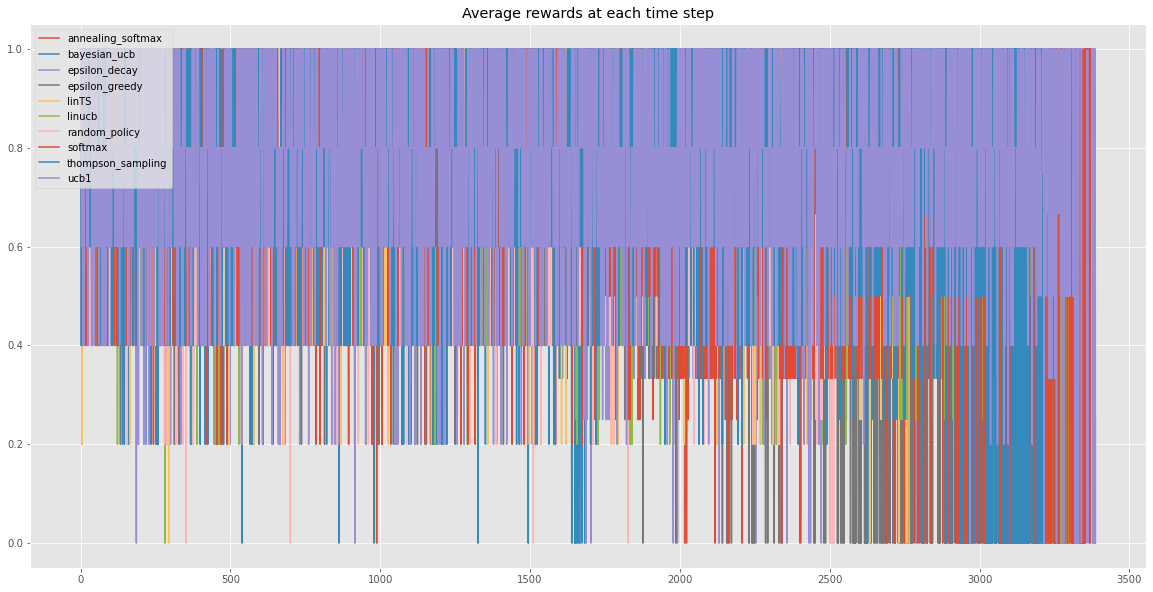

In [37]:
# Plot the rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for policy in final_evaluation_ber['policy'].unique():
    results_policy = final_evaluation_ber[final_evaluation_ber['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['reward'], label = str(policy))

plt.legend(loc = "upper left")
plt.title("Average rewards at each time step")

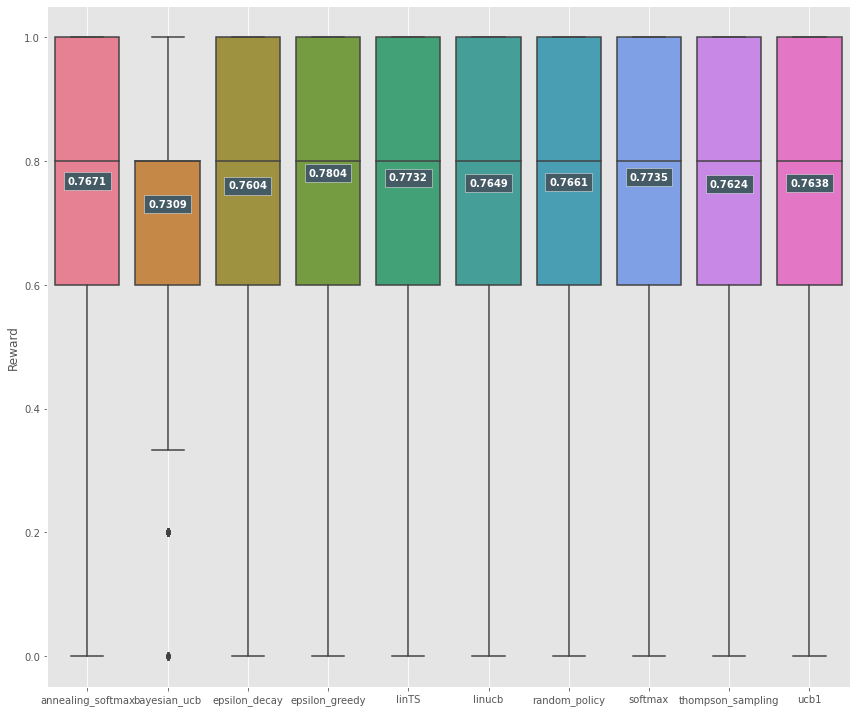

In [38]:
palette: str = "husl"
grouped: str = "policy"
default_value: str = "unknown"
target: str = "reward"

# Retrieve labels and additional parameters to plot figures
data_labels: dict = get_labels_colors_from_pandas_column(df = final_evaluation_ber, column = grouped, palette = palette)

plot_multiple_boxplots(data=final_evaluation_ber,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

In [39]:
# Determine the cumulative reward at 1000 time step
final_evaluation_ber.groupby(['policy'], as_index = False).aggregate({"cumulative_reward":"max"}).sort_values(by=["cumulative_reward"], ascending = False)

,policy,cumulative_reward
7,softmax,2606.833333
3,epsilon_greedy,2593.416667
2,epsilon_decay,2575.550000
0,annealing_softmax,2566.683333
5,linucb,2559.416667
9,ucb1,2556.366667
8,thompson_sampling,2452.033333
4,linTS,2137.766667
6,random_policy,1926.066667
1,bayesian_ucb,1229.333333


Text(0.5, 1.0, 'Cumulative rewards at each step')

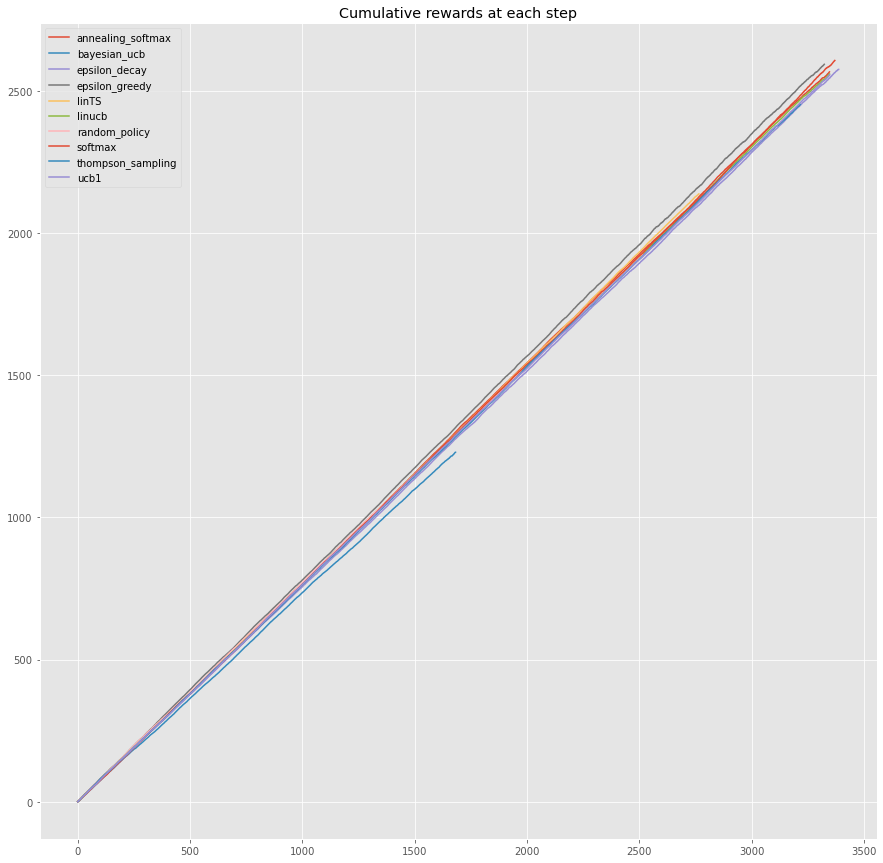

In [40]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation_ber['policy'].unique():
    results_policy = final_evaluation_ber[final_evaluation_ber['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))

plt.legend()
plt.title("Cumulative rewards at each step")

Text(0.5, 1.0, 'Cumulative rewards at each step')

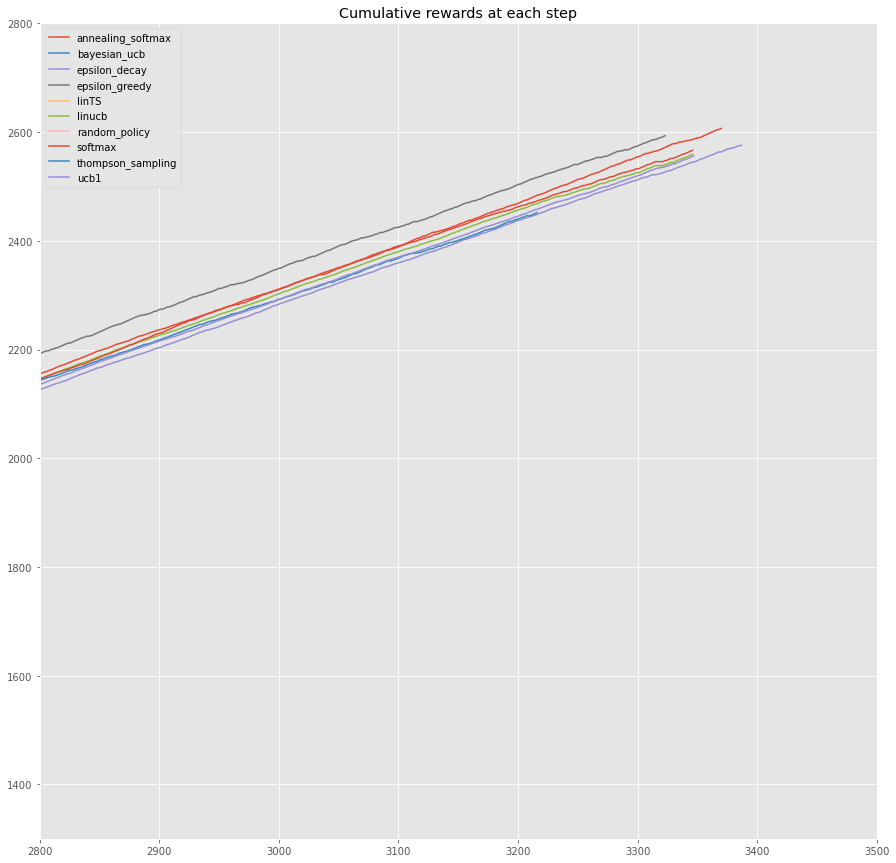

In [41]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation_ber['policy'].unique():
    results_policy = final_evaluation_ber[final_evaluation_ber['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))

plt.xlim(2800, 3500)
plt.ylim(1300, 2800)
plt.legend()
plt.title("Cumulative rewards at each step")

## Categorical Arm

In [42]:
# Set seed for reproducibility
random.seed(4014)
np.random.seed(4014)

# Retrieving resamples
bsamples = bootstrap_samples(logs_df, n_samples)

# The algos used
algos = [random_policy, epsilon_decay, annealing_softmax, ucb1, epsilon_greedy, softmax, linucb, linTS]
# algos = [annealing_softmax]

# Define a dataframe for evaluation results
evaluation_cat = []

# Define a list to save all arm-play statistics
play_stats = []

count_algos = 0

# Running bootstrap replay
for f in algos:
    
    count_algos += 1
    
    # Count samples
    sample_no = 0

    for bsample in bsamples:
        # Define a container to store all knowledge you have learned for arm
        container_cols = ['arm', 'mean', 'count', 'cat_dict', 'A', 'b', 'B', 'mu_hat', 'F']
        container = pd.DataFrame(data = None, columns = container_cols)
        container = container.astype({'arm': 'int32', 'mean': 'float', 'count': 'float'})
        
        A = np.identity(2) # n_features = 2
        b = np.zeros(2)
        B = np.identity(2)
        mu_hat = np.zeros(2)
        F = np.zeros(2)
        
        # To keep track of categories count
        categories_dict = {'Dead': 0, 'Alive and still dependent': 0, 'Alive and recovered': 0, 'Alive with unknown status': 0}
        
        for j in range(0, len(arms)):
            container.loc[j] = [arms[j], 0, 0, categories_dict, A, b, B, mu_hat, F]
        
        step = 0
        sample_no += 1

        # Go through every entry of the dataframe
        for i in range(1, log_length* len(arms) + 1):
            # Get recommendation from the algorithm
            if count_algos < 5:
                rec_a = f(container, arms)
            elif count_algos >= 7:
                # Context (for contextual bandits) --> size = n_features
                context = np.array([bsample.iloc[i - 1]['AGE_new'], bsample.iloc[i - 1]['SEX_new']])
                rec_a = f(container, arms, context)
            elif count_algos == 5:
                rec_a = f(container, arms, 0.2)
            else:
                rec_a = f(container, arms, 0.3)
            
            # Check if the recommendation matches the record at the step
            # If it does match, add to history so that the reward of this record can be revealed to the algorithm
            if rec_a == bsample.iloc[i - 1]['TREATMENT']:
                step = step + 1 # number of valid record to keep
                action = bsample.iloc[i - 1]['TREATMENT'] # to see which arm is chosen
                reward = bsample.iloc[i - 1]['REWARD_VALUE (CAT)'] # get the reward value
                regret = 3 - reward
                category = bsample.iloc[i - 1]['REWARD_CATEGORICAL']
                
                # Get features
                sex = bsample.iloc[i - 1]['SEX']
                age = bsample.iloc[i - 1]['AGE']

                # Add to history
                eva_rec = {'policy': f.__name__, 'chosen_arm': action, 'time_step': step, 'sample': sample_no, 'sex': sex, 'age': age, 'reward': reward, 'regret': regret}
                evaluation_cat.append(eva_rec)
                
                # Update reward category
                container['cat_dict'][action - 1][category] = container['cat_dict'][action - 1][category] + 1
                new_estimated_prob = container['cat_dict'][action - 1][category] / sum(container['cat_dict'][action - 1].values())

                # Keeps a record of the recommendation between the bandit and the data
                container['count'] = np.where(container['arm'] == action, container['count'] + 1, container['count'])
                container['mean'] = np.where(container['arm'] == action, new_estimated_prob, container['mean'])
                if count_algos == 7:
                    container['A'][action - 1] = container['A'][action - 1] + np.outer(context, context)
                    container['b'][action - 1] = container['b'][action - 1] + new_estimated_prob * context
                if count_algos == 8:
                    container['B'][action - 1] = container['B'][action - 1] + context.dot(context.T)
                    container['F'][action - 1] = container['F'][action - 1] + new_estimated_prob * context
                    container['mu_hat'][action - 1] = np.linalg.inv(container['B'][action - 1]).dot(container['F'][action - 1])
            # If it does not match, discard and move to the next iteration 
            else:
                continue

        container['policy'] = f.__name__
        play_stats.append(container)

In [43]:
evaluation_cat = pd.DataFrame(evaluation_cat)
evaluation_cat_policy = evaluation_cat.sort_values(by=['policy','time_step'])
evaluation_cat_policy

,policy,chosen_arm,time_step,sample,sex,age,reward,regret
22567,annealing_softmax,2,1,1,F,OLD,2,1
24602,annealing_softmax,1,1,2,M,YOUNG,3,0
26496,annealing_softmax,1,1,3,M,YOUNG,2,1
28375,annealing_softmax,2,1,4,M,OLD,2,1
30709,annealing_softmax,3,1,5,M,OLD,3,0
...,...,...,...,...,...,...,...,...
40634,ucb1,1,3343,2,M,OLD,3,0
40635,ucb1,1,3344,2,F,OLD,3,0
40636,ucb1,1,3345,2,M,OLD,3,0
40637,ucb1,1,3346,2,M,OLD,2,1


In [44]:
final_evaluation_cat = evaluation_cat_policy.groupby(['policy', 'time_step'], as_index = False).aggregate({"reward":"mean", 
                                                                                                           "regret":"mean"})

final_evaluation_cat['cumulative_reward'] = final_evaluation_cat.groupby(['policy'])['reward'].cumsum()
final_evaluation_cat['cumulative_regret'] = final_evaluation_cat.groupby(['policy'])['regret'].cumsum()
final_evaluation_cat

,policy,time_step,reward,regret,cumulative_reward,cumulative_regret
0,annealing_softmax,1,2.4,0.6,2.40,0.60
1,annealing_softmax,2,2.0,1.0,4.40,1.60
2,annealing_softmax,3,2.0,1.0,6.40,2.60
3,annealing_softmax,4,1.4,1.6,7.80,4.20
4,annealing_softmax,5,1.4,1.6,9.20,5.80
...,...,...,...,...,...,...
23138,ucb1,3343,3.0,0.0,6296.95,3732.05
23139,ucb1,3344,3.0,0.0,6299.95,3732.05
23140,ucb1,3345,3.0,0.0,6302.95,3732.05
23141,ucb1,3346,2.0,1.0,6304.95,3733.05


In [45]:
evaluation_cat_treatment = evaluation_cat.sort_values(by=['policy', 'sample', 'time_step'])
evaluation_cat_treatment_F = evaluation_cat_treatment[evaluation_cat_treatment['sex'] == 'F']
evaluation_cat_treatment_M = evaluation_cat_treatment[evaluation_cat_treatment['sex'] == 'M']
evaluation_cat_treatment_Y = evaluation_cat_treatment[evaluation_cat_treatment['age'] == 'YOUNG']
evaluation_cat_treatment_O = evaluation_cat_treatment[evaluation_cat_treatment['age'] == 'OLD']

In [46]:
evaluation_cat_groupedtreatment_F = evaluation_cat_treatment_F.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [47]:
evaluation_cat_groupedtreatment_F = evaluation_cat_groupedtreatment_F.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_cat_groupedtreatment_F

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,1.625904,1.374096
1,annealing_softmax,2,1.714603,1.285397
2,annealing_softmax,3,1.754821,1.245179
3,annealing_softmax,4,1.883696,1.116304
4,epsilon_decay,1,1.640748,1.359252
5,epsilon_decay,2,1.715731,1.284269
6,epsilon_decay,3,1.848783,1.151217
7,epsilon_decay,4,1.848846,1.151154
8,epsilon_greedy,1,1.702258,1.297742
9,epsilon_greedy,2,1.687059,1.312941


In [48]:
evaluation_cat_groupedtreatment_M = evaluation_cat_treatment_M.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [49]:
evaluation_cat_groupedtreatment_M = evaluation_cat_groupedtreatment_M.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_cat_groupedtreatment_M

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,1.875088,1.124912
1,annealing_softmax,2,1.914563,1.085437
2,annealing_softmax,3,1.619833,1.380167
3,annealing_softmax,4,1.581728,1.418272
4,epsilon_decay,1,2.056327,0.943673
5,epsilon_decay,2,1.920866,1.079134
6,epsilon_decay,3,2.009142,0.990858
7,epsilon_decay,4,2.041868,0.958132
8,epsilon_greedy,1,2.009022,0.990978
9,epsilon_greedy,2,1.877754,1.122246


In [50]:
evaluation_cat_groupedtreatment_Y = evaluation_cat_treatment_Y.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [51]:
evaluation_cat_groupedtreatment_Y = evaluation_cat_groupedtreatment_Y.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_cat_groupedtreatment_Y

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,2.237010,0.762990
1,annealing_softmax,2,2.190886,0.809114
2,annealing_softmax,3,2.261824,0.738176
3,annealing_softmax,4,1.838775,1.161225
4,epsilon_decay,1,2.243758,0.756242
5,epsilon_decay,2,2.195191,0.804809
6,epsilon_decay,3,2.276513,0.723487
7,epsilon_decay,4,2.310488,0.689512
8,epsilon_greedy,1,2.246147,0.753853
9,epsilon_greedy,2,2.259150,0.740850


In [52]:
evaluation_cat_groupedtreatment_O = evaluation_cat_treatment_O.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [53]:
evaluation_cat_groupedtreatment_O = evaluation_cat_groupedtreatment_O.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_cat_groupedtreatment_O

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,1.509882,1.490118
1,annealing_softmax,2,1.613866,1.386134
2,annealing_softmax,3,1.546690,1.453310
3,annealing_softmax,4,1.733601,1.266399
4,epsilon_decay,1,1.643273,1.356727
5,epsilon_decay,2,1.619251,1.380749
6,epsilon_decay,3,1.722265,1.277735
7,epsilon_decay,4,1.714551,1.285449
8,epsilon_greedy,1,1.638931,1.361069
9,epsilon_greedy,2,1.537520,1.462480


## Test Stats

### Comparing between Algorithms
Is there a difference in performance between the different multi-armed bandit algorithms?

In [54]:
epsilon_greedy_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'epsilon_greedy']['reward'])
epsilon_decay_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'epsilon_decay']['reward'])
softmax_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'softmax']['reward'])
annealing_softmax_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'annealing_softmax']['reward'])
ucb1_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'ucb1']['reward'])
linucb_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'linucb']['reward'])
lints_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'linTS']['reward'])

kruskal(epsilon_greedy_rewards, epsilon_decay_rewards, softmax_rewards, annealing_softmax_rewards, 
         ucb1_rewards, linucb_rewards, lints_rewards)

KruskalResult(statistic=12.81776657070341, pvalue=0.04602285157445336)

In [55]:
tukey_df_algo_cat = final_evaluation_cat[['policy', 'reward']]
tukey_df_algo_cat = tukey_df_algo_cat.groupby(['policy'], as_index = False).aggregate({"reward":"mean"})

dunn_cat = sp.posthoc_dunn(tukey_df_algo_cat, val_col = 'reward', group_col = 'policy')

def highlight_cell(cell_value):
    if cell_value < 0.05:
        return "background-color: yellow"

dunn_cat = dunn_cat.style.applymap(highlight_cell)
dfi.export(dunn_cat, 'bernoulli_dunn.png')
dunn_cat

C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
C:\Program Files (x86)\Google\Chrome\Application\chrome.exe


,annealing_softmax,epsilon_decay,epsilon_greedy,linTS,linucb,random_policy,softmax,ucb1
annealing_softmax,1.000000,0.772830,0.772830,0.386476,0.083265,0.148915,0.248213,0.563703
epsilon_decay,0.772830,1.000000,0.563703,0.248213,0.043308,0.083265,0.148915,0.386476
epsilon_greedy,0.772830,0.563703,1.000000,0.563703,0.148915,0.248213,0.386476,0.772830
linTS,0.386476,0.248213,0.563703,1.000000,0.386476,0.563703,0.772830,0.772830
linucb,0.083265,0.043308,0.148915,0.386476,1.000000,0.772830,0.563703,0.248213
random_policy,0.148915,0.083265,0.248213,0.563703,0.772830,1.000000,0.772830,0.386476
softmax,0.248213,0.148915,0.386476,0.772830,0.563703,0.772830,1.000000,0.563703
ucb1,0.563703,0.386476,0.772830,0.772830,0.248213,0.386476,0.563703,1.000000


In [56]:
# f_oneway(epsilon_greedy_rewards, epsilon_decay_rewards, softmax_rewards, annealing_softmax_rewards, 
#          ucb1_rewards, linucb_rewards, lints_rewards)

# tukey_algo_cat = pairwise_tukeyhsd(endog=tukey_df_algo_cat['reward'],
#                                    groups=tukey_df_algo_cat['policy'],
#                                    alpha=0.05)

# print(tukey_algo_cat)

### Comparing for Treatments 
For each treatment method, is there a difference in performance between different age groups or different sex?


In [57]:
evaluation_cat_groupedtreatment_F1 = evaluation_cat_groupedtreatment_F[evaluation_cat_groupedtreatment_F['chosen_arm'] == 1]
evaluation_cat_groupedtreatment_F2 = evaluation_cat_groupedtreatment_F[evaluation_cat_groupedtreatment_F['chosen_arm'] == 2]
evaluation_cat_groupedtreatment_F3 = evaluation_cat_groupedtreatment_F[evaluation_cat_groupedtreatment_F['chosen_arm'] == 3]
evaluation_cat_groupedtreatment_F4 = evaluation_cat_groupedtreatment_F[evaluation_cat_groupedtreatment_F['chosen_arm'] == 4]

evaluation_cat_groupedtreatment_M1 = evaluation_cat_groupedtreatment_M[evaluation_cat_groupedtreatment_M['chosen_arm'] == 1]
evaluation_cat_groupedtreatment_M2 = evaluation_cat_groupedtreatment_M[evaluation_cat_groupedtreatment_M['chosen_arm'] == 2]
evaluation_cat_groupedtreatment_M3 = evaluation_cat_groupedtreatment_M[evaluation_cat_groupedtreatment_M['chosen_arm'] == 3]
evaluation_cat_groupedtreatment_M4 = evaluation_cat_groupedtreatment_M[evaluation_cat_groupedtreatment_M['chosen_arm'] == 4]

In [58]:
sex_1 = ttest_ind(evaluation_cat_groupedtreatment_F1['reward'], evaluation_cat_groupedtreatment_M1['reward'])
sex_2 = ttest_ind(evaluation_cat_groupedtreatment_F2['reward'], evaluation_cat_groupedtreatment_M2['reward'])
sex_3 = ttest_ind(evaluation_cat_groupedtreatment_F3['reward'], evaluation_cat_groupedtreatment_M3['reward'])
sex_4 = ttest_ind(evaluation_cat_groupedtreatment_F4['reward'], evaluation_cat_groupedtreatment_M4['reward'])
print(f'Treatment 1 (sex): {sex_1}')
print(f'Treatment 2 (sex): {sex_2}')
print(f'Treatment 3 (sex): {sex_3}')
print(f'Treatment 4 (sex): {sex_4}')

Treatment 1 (sex): Ttest_indResult(statistic=-4.243695639287867, pvalue=0.0008180879112953197)
Treatment 2 (sex): Ttest_indResult(statistic=0.7580378493678097, pvalue=0.4609988966148948)
Treatment 3 (sex): Ttest_indResult(statistic=-1.6635793858845396, pvalue=0.12207188916490372)
Treatment 4 (sex): Ttest_indResult(statistic=-0.9085285781208396, pvalue=0.3849716517160545)


In [59]:
evaluation_cat_groupedtreatment_Y1 = evaluation_cat_groupedtreatment_Y[evaluation_cat_groupedtreatment_Y['chosen_arm'] == 1]
evaluation_cat_groupedtreatment_Y2 = evaluation_cat_groupedtreatment_Y[evaluation_cat_groupedtreatment_Y['chosen_arm'] == 2]
evaluation_cat_groupedtreatment_Y3 = evaluation_cat_groupedtreatment_Y[evaluation_cat_groupedtreatment_Y['chosen_arm'] == 3]
evaluation_cat_groupedtreatment_Y4 = evaluation_cat_groupedtreatment_Y[evaluation_cat_groupedtreatment_Y['chosen_arm'] == 4]

evaluation_cat_groupedtreatment_O1 = evaluation_cat_groupedtreatment_O[evaluation_cat_groupedtreatment_O['chosen_arm'] == 1]
evaluation_cat_groupedtreatment_O2 = evaluation_cat_groupedtreatment_O[evaluation_cat_groupedtreatment_O['chosen_arm'] == 2]
evaluation_cat_groupedtreatment_O3 = evaluation_cat_groupedtreatment_O[evaluation_cat_groupedtreatment_O['chosen_arm'] == 3]
evaluation_cat_groupedtreatment_O4 = evaluation_cat_groupedtreatment_O[evaluation_cat_groupedtreatment_O['chosen_arm'] == 4]

In [60]:
age_1 = ttest_ind(evaluation_cat_groupedtreatment_Y1['reward'], evaluation_cat_groupedtreatment_O1['reward'])
age_2 = ttest_ind(evaluation_cat_groupedtreatment_Y2['reward'], evaluation_cat_groupedtreatment_O2['reward'])
age_3 = ttest_ind(evaluation_cat_groupedtreatment_Y3['reward'], evaluation_cat_groupedtreatment_O3['reward'])
age_4 = ttest_ind(evaluation_cat_groupedtreatment_Y4['reward'], evaluation_cat_groupedtreatment_O4['reward'])
print(f'Treatment 1 (age): {age_1}')
print(f'Treatment 2 (age): {age_2}')
print(f'Treatment 3 (age): {age_3}')
print(f'Treatment 4 (age): {age_4}')

Treatment 1 (age): Ttest_indResult(statistic=22.51484972395716, pvalue=2.146862984371244e-12)
Treatment 2 (age): Ttest_indResult(statistic=3.1425638247418757, pvalue=0.007782254128250769)
Treatment 3 (age): Ttest_indResult(statistic=0.9098885682449686, pvalue=0.3807941478428941)
Treatment 4 (age): Ttest_indResult(statistic=3.5498509726405643, pvalue=0.003997740669618645)


## Reward

Text(0.5, 1.0, 'Average rewards at each time step')

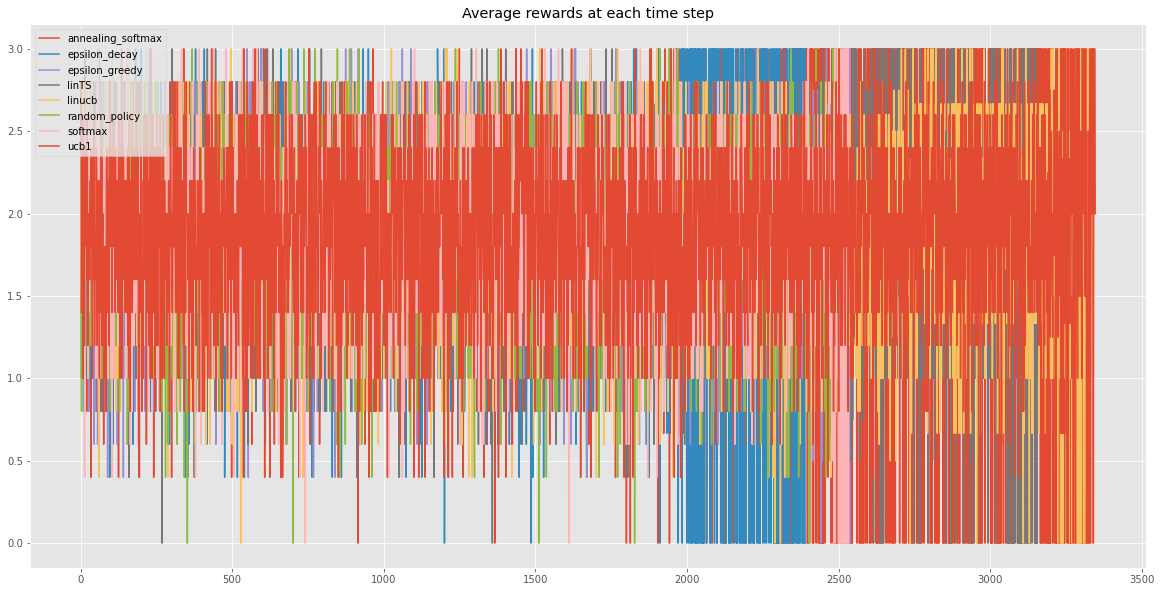

In [61]:
# Plot the rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for policy in final_evaluation_cat['policy'].unique():
    results_policy = final_evaluation_cat[final_evaluation_cat['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['reward'], label = str(policy))
plt.legend(loc = "upper left")
plt.title("Average rewards at each time step")

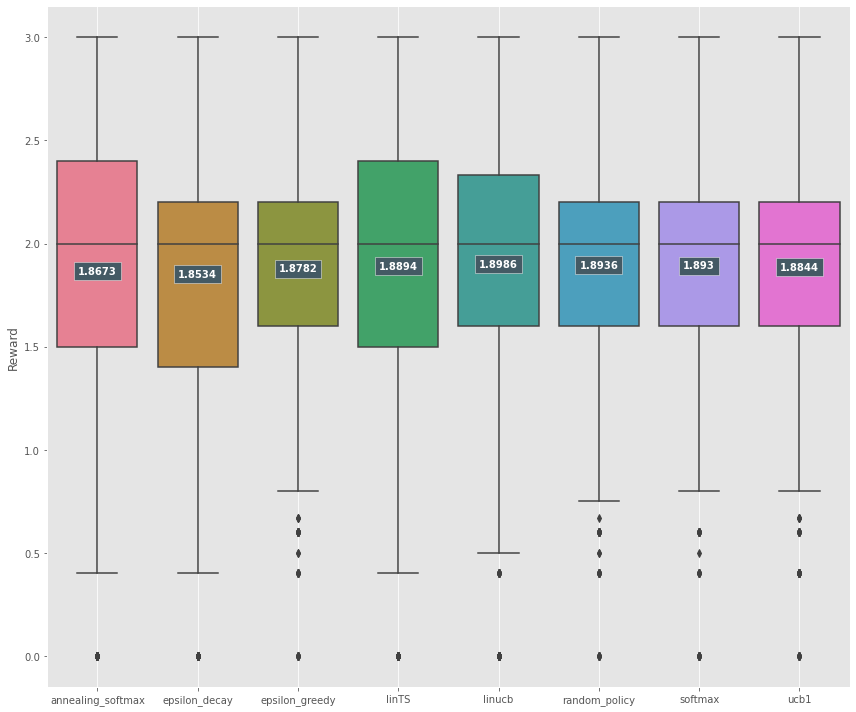

In [62]:
palette: str = "husl"
grouped: str = "policy"
default_value: str = "unknown"
target: str = "reward"

# Retrieve labels and additional parameters to plot figures
data_labels: dict = get_labels_colors_from_pandas_column(df = final_evaluation_cat, column = grouped, palette = palette)

plot_multiple_boxplots(data=final_evaluation_cat,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

In [63]:
# Determine the cumulative reward at 1000 time step
final_evaluation_cat.groupby(['policy'], as_index = False).aggregate({"cumulative_reward":"max"}).sort_values(by=["cumulative_reward"], ascending = False)

,policy,cumulative_reward
4,linucb,6352.650000
7,ucb1,6306.950000
0,annealing_softmax,6197.433333
3,linTS,5961.100000
6,softmax,4795.083333
2,epsilon_greedy,4766.933333
5,random_policy,4760.433333
1,epsilon_decay,4431.550000


Text(0.5, 1.0, 'Cumulative rewards at each step')

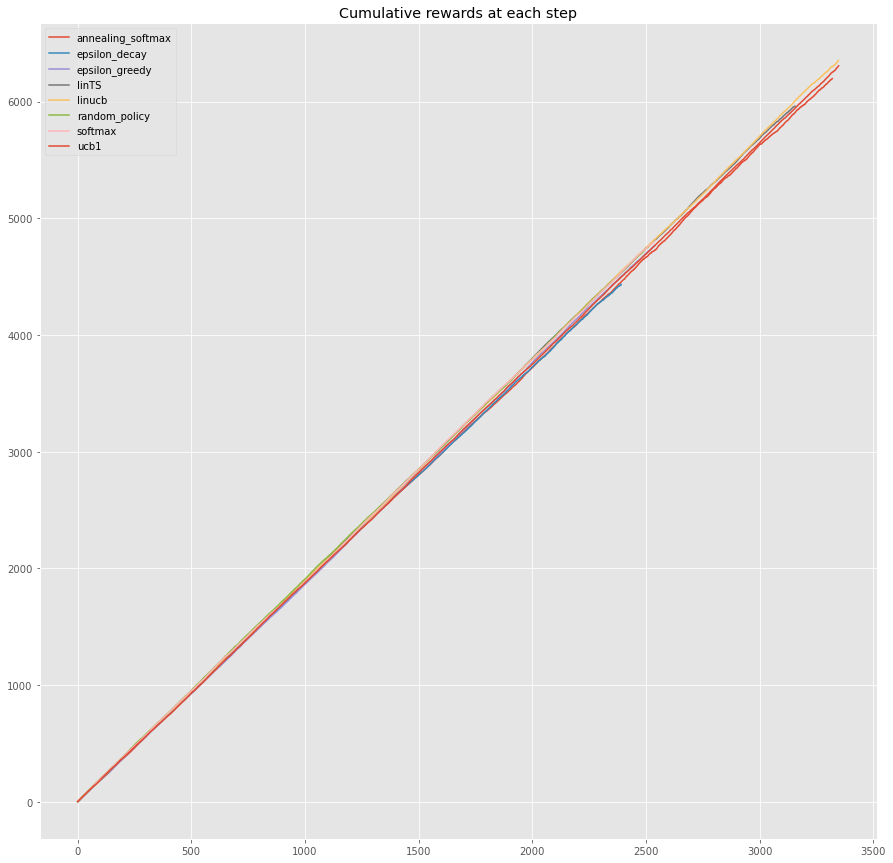

In [64]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation_cat['policy'].unique():
    results_policy = final_evaluation_cat[final_evaluation_cat['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))

plt.legend()
plt.title("Cumulative rewards at each step")

Text(0.5, 1.0, 'Cumulative rewards at each step')

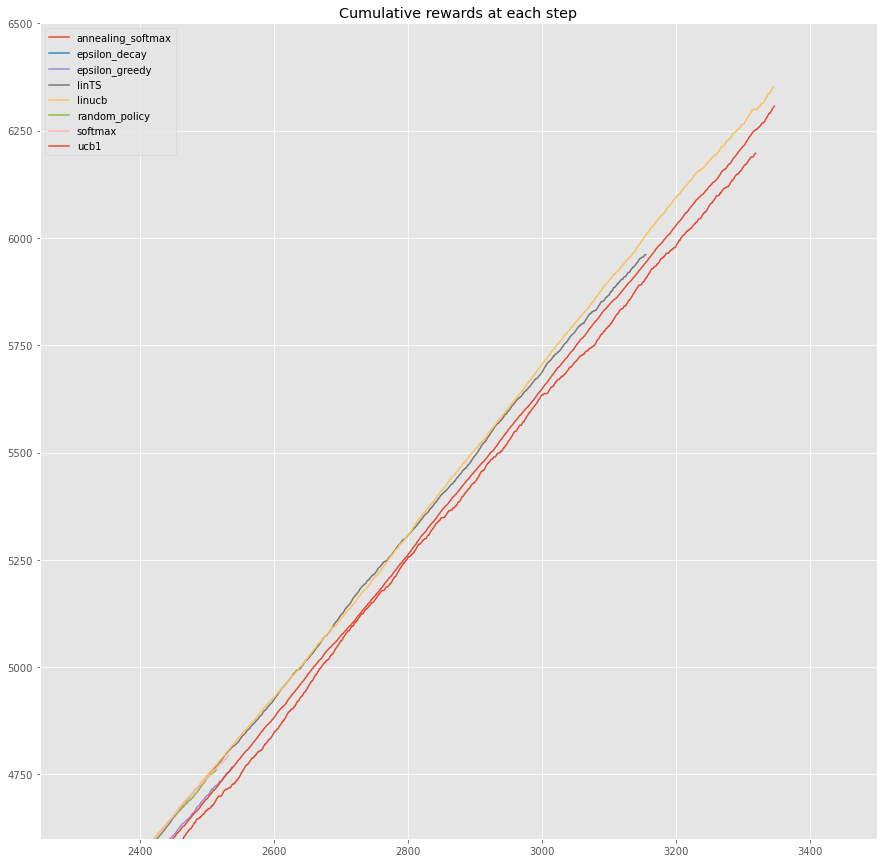

In [65]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation_cat['policy'].unique():
    results_policy = final_evaluation_cat[final_evaluation_cat['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))
    
plt.xlim(2250, 3500)
plt.ylim(4600, 6500)
plt.legend()
plt.title("Cumulative rewards at each step")